# True Batting Averages using Bayesian Statistics

This is an example of what's possible using Bayesian inference.


### MLB Batting Averages
A baseball player's batting average is defined by the number of times he has hit the ball (to get onto base) divided by the total number of times he has been at bat--his batting average is somewere between 0 and 1. 

An batting average of .270 is considered average, while the best BA was by outfielder Ty Cobb with .366 over 24 seasons.

Let's pretend that every player has a "true" batting average, and that over the course of many hits he converges to his true batting average, $p$.




# New Player Has Entered the Game

Let's pretend there's a new player on the block, Derek Jitter. His "true batting average" is .450 (i.e. off the charts), but since he's new to the game, no one knows what his average would be. Through the course of this notebook, we will explore _frequentist_ and _Bayesian_ ways of estimating $p$, or his probability of hitting through the course of many at bat attempts.

Let's generate a sample of his first 40 hits.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

In [35]:
p = .45  # probability of Derek hitting the ball at bat
N = 30  # number of at bats
pitches = np.random.random(N) < p  # uniform distribution
print " ".join(list("MH")[pitch] for pitch in pitches)
print "Batting Avg over 40 at bats:", pitches.mean()

H M M H M M M M H M H H H M M H M H H M H H M M H M M M M M
Batting Avg over 40 at bats: 0.4


# Frequentist Beliefs

Pretend that we did not know Derek's true batting average of .450. All we can observe are his hits over time.

The _frequentist_ interpretation would say that his true BA is:

$$P(p|ab) = \frac{h}{N}$$

read as "The probability of Derek's probability of hitting (i.e. batting average) being equal to 'p' given the number of times at bat (ab) is the number of hits (h) divided by the total number of times at bat (N)."

This makes intuitive sense--we can estimate some players batting average (**i.e. probability of him hitting when at bat**), by taking the fraction of times he has hit per times at bat.

Frequentist belief of p: 0.4
H M M H M M M M H M H H H M M H M H H M H H M M H M M M M M


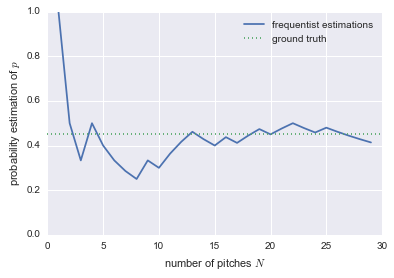

In [36]:
def frequentist(pitches):
    return pitches.mean()

print "Frequentist belief of p:", frequentist(pitches)

freq = [frequentist(pitches[:n]) for n in xrange(1, N)]
f = plt.plot(range(1, N), freq, label="frequentist estimations")
f = plt.plot([0, N], [p, p], ":", label="ground truth")
f = plt.legend(), plt.ylim(0, 1)
f = plt.xlabel("number of pitches $N$"), plt.ylabel("probability estimation of $p$")
print " ".join(list("MH")[pitch] for pitch in pitches)


As you can see, depending on how the samples were picked, Derek's BA at his start might be extremely high (1.0) or extremely bad (0.0). Over many pitches, we may start to get a true idea of his true batting average, $p$.

# Turn the Bayesian Crank

Let's compute Derek's probability of hitting (i.e. batting average) the Bayesian way.

For readability's sake, let's simply write $P(p)$ for $P(P(H) = p)$ and  $P(D)$ for $P(\text{pitches})$ (using the $D$ for data).

We can write Bayes' theorem in this way:

$$P(p|D) = \frac{P(D|p) \times P(p)}{P(D)}$$

So this reads: given our data $D$, i.e., Derek's observed pitches, what is the probability that $P(H)$ is $p$, or, what is the probability that his true batting average is p? 

Since we're interested in which $p$ will give us the _maximum a posteriori likelihood (MAP)_ estimate, we can drop the denominator since the factor $P(D)$ does not depend on $p$.

$$\max_p P(p|D) = \max_p P(D|p) P(p) $$

Working with products of probabilities gets very tedious as the numbers get too small to be suitable for computing. We often take the logarithm of both sides, so the computations get easier. This won't change the maximum $p$.

$$\max_p \log P(p|D) = \max_p \big(\log P(D|p) + \log P(p) \big)$$

### Prior distribution

So we'll need a **prior** belief for $p$. This is always a very subjective step. If you have absolutely no idea, you could take the uniform distribution in this case, but you probably feel as well that the limit cases $p=0$ and $p=1$ are very unlikely for a coin toss – or even impossible. So we will pick some Beta distribution. In fact, we will choose the Beta(5,11) distribution to account for our belief that most players bat average is at .270.

$$P(p) = Beta(5,11)=15015 * p^{4}(1-p)^{10}$$.

[Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution) The beta distribution is a distribution that essentially represents probability of probabilities. 

[Beta Intuition](http://stats.stackexchange.com/questions/47771/what-is-the-intuition-behind-beta-distribution) More easily understood through this link

Note that $P(p) = 0$ for $p = 0$ or $1$. The constant 15015 is to make the area under the curve equal to one. If we had different prior beliefs, we could change all of the $\alpha$ and $\beta$ coefficients and/or the entire distribution.

In [37]:
from scipy.stats import beta

def prior(p):
    return beta.pdf(p,5,11)

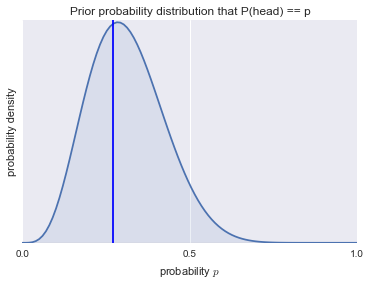

In [38]:
x = np.linspace(0, 1, 100)
f = plt.plot(x, prior(x))
f = plt.fill_between(x, prior(x), 0, alpha=.1)
f = plt.axvline(x=.270) 
f = plt.title("Prior probability distribution that P(head) == p")
f = plt.xlabel("probability $p$"), plt.ylabel("probability density"), plt.xticks([0, .5, 1]), plt.yticks([])

### Likelihood Function

Remember that we want to estimate Derek's true batting average, aka, his probability of hitting per times at bat. To do that, we are using the MAP estimate:
$$\max_p \log P(p|D) = \max_p \big(\log P(D|p) + \log P(p) \big)$$




We have the **prior** distribution function, which we've estimated using a beta(5,11) distribution. But we also need the **likelihood** function $P(D|p)$. This is the reversed question: given any probability $p$, what is the chance I'd see the observed set of hits and misses $D$? It depends on how we represent $D$, what this function is, i.e., are we just counting the number of hits, or are we maintaining the order of hits and misses? Let's say the precise order does not matter, then we'd have the Binomial distribution:

$$P(D|p) = {N\choose n} p^n (1-p)^{N-n},$$
where $n$ is the number of hits, and $N$ is the total number of at bats. If we would care about order, we would drop the ${N\choose n}$ part. For the eventual Bayesian results, this choice does not matter.

It follows that the _log likelihood_ is equal to

$$\log P(D|p) = \log {N\choose n} + n \log p + (N-n) \log (1-p).$$

Combining the likelihood with the prior function, we get the following formula. Note that we're interested in finding the maximum $p$, so we can drop all constants again.

$$\begin{equation} 
\begin{split}
\max_p \log P(p|D) \log P(p)
&= \max_p \big(n \log p + (N-n) \log (1-p) + 4 \log p + 10 \log (1-p)\big) \\
&= \max_p \big((n+4) \log p + (N-n+10) \log (1-p) \big)
\end{split}
\end{equation}$$

Note that this has a maximum if its derivate to $p$ is zero:
$$\begin{equation} 
\begin{split}
\frac{d}{dp} \log P(p|D) &=  0 \\
\frac{n+4}{p} - \frac{N-n+10}{1-p} &= 0 \\
p = \frac{n+4}{N+14}
\end{split}
\end{equation}$$


That's it! According to Bayes, the probability of Derek hitting the ball is equal to $p = \frac{n+4}{N+14}$, where $n$ of the number of hits and $N$ the number of total pitches. 

As a side remark, note that in this starightforward example it wasn't necessary to take the log of both sides. We still did so, however, since it is a very common step in most Bayesian estimations, so having seen it already would make you better prepared. Also, in our further analysis, we'll use these functions to estimate the distributions.

In [39]:
def bayesian(pitches):
    n_hits = pitches.sum()
    n_misses = len(pitches) - n_hits
    N       = len(pitches)
    return (n_hits+4)/float(N + 14)

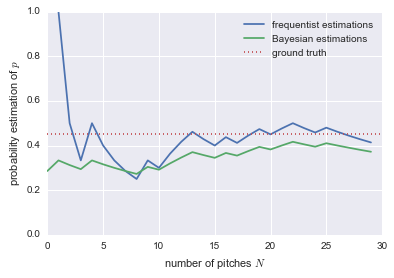

In [40]:
bayes = [bayesian(pitches[:n]) for n in xrange(N)]
f = plt.plot(range(1, N), freq, label="frequentist estimations")
f = plt.plot(range(0, N), bayes, label="Bayesian estimations")
f = plt.plot([0, N], [p, p], ":", label="ground truth")
f = plt.legend(), plt.ylim(0, 1)
f = plt.xlabel("number of pitches $N$"), plt.ylabel("probability estimation of $p$")

* Bayes starts at roughly .270, our prior belief. As Derek goes to bat more often, the bayes estimate converges toward the frequentist estimations.
* Notice at first, the frequentist estimates $p$ can be quite wild.
* The Bayesian estimates are much more realistic and less volatile

If you want to build your next Data Science startup but don't have much data, Bayesian methods provide much smoother estimates.

### Posterior distributions

As mentioned earlier, Bayes does not only provide a point estimate for $p$, but a full likelihood distribution as well. Let's plot some a posteriori likelihood distributions for some number of pitches $N$.

In [41]:
def log_prior(p):
    """What is the prior probability that P(hit) == p?"""
    return 4*np.log(p) + 10*np.log(1 - p) 

def log_likelihood(p, pitches):
    """What is the likelihood that that P(hit) == p, given the observed data?"""
    return np.log(pitches * p + (1 - pitches) * (1 - p)).sum()

def log_posterior(p, pitches):
    """What is the a posteriori likelihood that that P(head) == p, given the prior and the data?"""
    return log_likelihood(p, pitches) + log_prior(p)

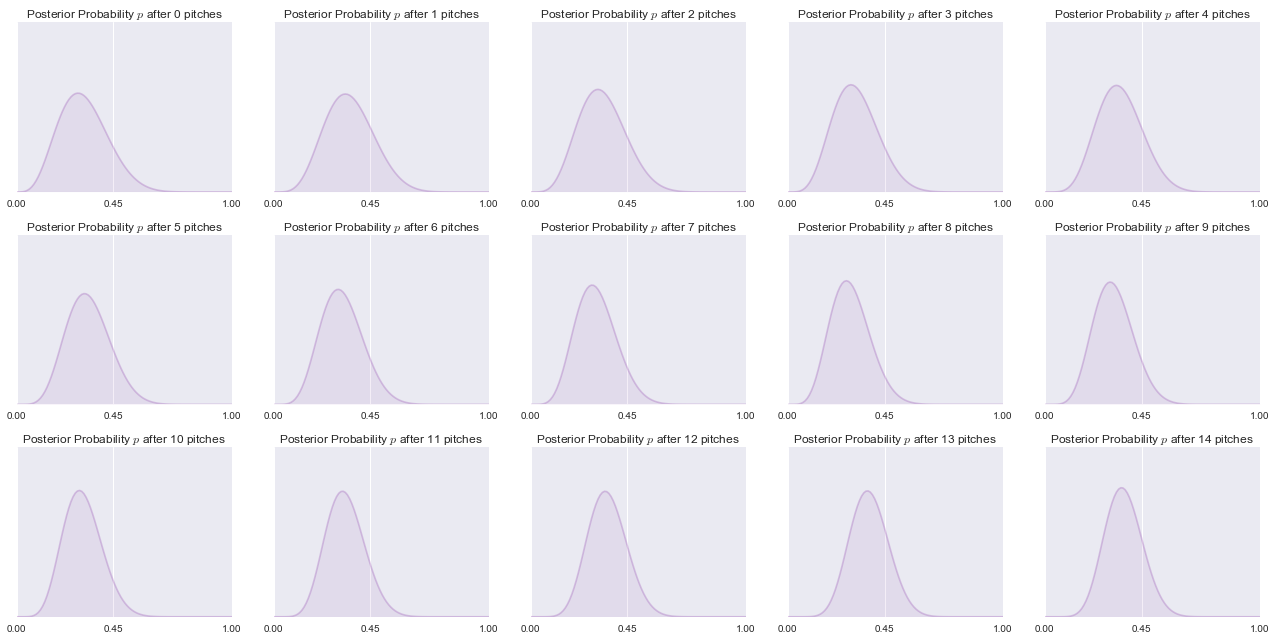

In [42]:
n_rows = 3
fig, axes = plt.subplots(n_rows, 5, figsize=(18, 3 * n_rows))
# x = np.linspace(0, 1, 100)
for k in xrange(n_rows * 5):
    y = np.exp(np.array([log_posterior(q, pitches=pitches[:k]) for q in x]))
    y = y / y.sum() * len(x)  # normalize, so that area under the curve is one again
    axes[k / 5, k % 5].set_title("Posterior Probability $p$ after %d pitches" % k)
    axes[k / 5, k % 5].plot(x, y, c="#9b59b6", alpha=.3, label=k)
    axes[k / 5, k % 5].fill_between(x, y, -0, color="#9b59b6", alpha=.1)
    axes[k / 5, k % 5].set_ylim(0, 6), axes[k / 5, k % 5].set_xticks([0, p, 1]), axes[k / 5, k % 5].set_yticks([])
f = plt.tight_layout()

As you can see, 
- the curve for $N=0$ is exactly our prior belief,
- the top of the curve moves to $p$, albeit not straight (but following the graph we saw earlier),
- the standard deviation gets smaller as $N$ increases, meaning we get more and more confident about our estimations.

### Likelihood distributions

We can also look at the likelihood distributions, which denote the likelihood of the data given some $p$, and which does not account for our prior belief.

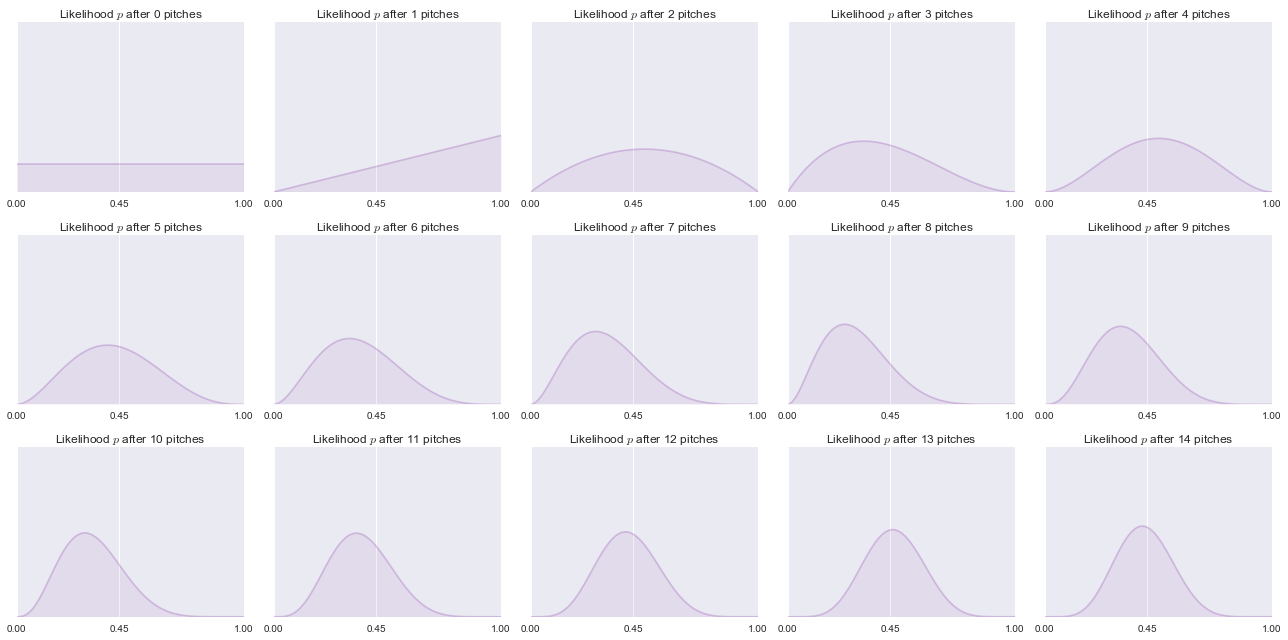

In [43]:
n_rows = 3
fig, axes = plt.subplots(n_rows, 5, figsize=(18, 3 * n_rows))
for k in xrange(n_rows * 5):
    y = np.exp(np.array([log_likelihood(q, pitches[:k]) for q in x]))
    y = y / y.sum() * len(x)  # normalize, so that area under the curve is one again
    axes[k / 5, k % 5].set_title("Likelihood $p$ after %d pitches" % k)
    axes[k / 5, k % 5].plot(x, y, c="#9b59b6", alpha=.3, label=k)
    axes[k / 5, k % 5].fill_between(x, y, -0, color="#9b59b6", alpha=.1)
    axes[k / 5, k % 5].set_ylim(0, 6), axes[k / 5, k % 5].set_xticks([0, p, 1]), axes[k / 5, k % 5].set_yticks([])
f = plt.tight_layout()

As you can see, 
- the top of the curve moves to $p$ as well, albeit much more volatile,
- the shape very much resembles the posterior distribution for larger $N$,
- in particular, standard deviation gets smaller as $N$ increases, meaning we get more and more confident about our estimations.